In [13]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import dotenv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from isrobust.utils import set_all_seeds

project_path = Path(dotenv.find_dotenv()).parent
data_path = project_path.joinpath("data")

set_all_seeds(seed=42)

tf.config.experimental.enable_op_determinism()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
config = dotenv.dotenv_values()
frac_list = np.arange(
    float(config["FRAC_START"]),
    float(config["FRAC_STOP"]) + float(config["FRAC_STEP"]),
    float(config["FRAC_STEP"]),
)
frac_list

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ])

In [15]:
results_path = Path(config["RESULTS_FOLDER"])
figs_path = results_path.joinpath("figs")
tables_path = results_path.joinpath("tables")

In [16]:
models = ["ivae_kegg", "ivae_reactome"] + [
    f"ivae_random-{frac:.2f}" for frac in frac_list
]
models

['ivae_kegg',
 'ivae_reactome',
 'ivae_random-0.05',
 'ivae_random-0.10',
 'ivae_random-0.15',
 'ivae_random-0.20',
 'ivae_random-0.25',
 'ivae_random-0.30',
 'ivae_random-0.35',
 'ivae_random-0.40',
 'ivae_random-0.45',
 'ivae_random-0.50',
 'ivae_random-0.55',
 'ivae_random-0.60',
 'ivae_random-0.65',
 'ivae_random-0.70',
 'ivae_random-0.75',
 'ivae_random-0.80',
 'ivae_random-0.85',
 'ivae_random-0.90']

In [17]:
# Metrics

metric_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_metrics.pkl")) for m in models
]
metric_scores = pd.concat(metric_scores, axis=0, ignore_index=True)
metric_scores = metric_scores
metric_scores.head()

,seed,metric,split,score,model
0,0,loss,train,2.099017,ivae_kegg
1,0,mse,train,0.000771,ivae_kegg
2,0,loss,val,2.101533,ivae_kegg
3,0,mse,val,0.000773,ivae_kegg
4,0,loss,test,2.113942,ivae_kegg


In [18]:
# clustering

clustering_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_clustering.pkl")) for m in models
]
clustering_scores = pd.concat(clustering_scores, axis=0, ignore_index=True)
clustering_scores.head()

,split,layer,score,model
0,train,1,0.606398,ivae_kegg
1,train,1,0.641018,ivae_kegg
2,train,1,0.706496,ivae_kegg
3,train,1,0.629728,ivae_kegg
4,train,1,0.591613,ivae_kegg


In [19]:
clustering_scores.groupby(["model", "layer"]).size()

model             layer
ivae_kegg         1        300
                  2        300
ivae_random-0.05  1        300
ivae_random-0.10  1        300
ivae_random-0.15  1        300
ivae_random-0.20  1        300
ivae_random-0.25  1        300
ivae_random-0.30  1        300
ivae_random-0.35  1        300
ivae_random-0.40  1        300
ivae_random-0.45  1        300
ivae_random-0.50  1        300
ivae_random-0.55  1        300
ivae_random-0.60  1        300
ivae_random-0.65  1        300
ivae_random-0.70  1        300
ivae_random-0.75  1        300
ivae_random-0.80  1        300
ivae_random-0.85  1        300
ivae_random-0.90  1        300
ivae_reactome     1        300
dtype: int64

In [20]:
# informed

informed_scores = [
    pd.read_pickle(results_path.joinpath(m, "scores_informed.pkl")) for m in models
]
informed_scores = pd.concat(informed_scores, axis=0, ignore_index=True)
informed_scores.head()

,split,layer,score,model
0,train,1,0.823246,ivae_kegg
1,train,1,0.816320,ivae_kegg
2,train,1,0.820593,ivae_kegg
3,train,1,0.819062,ivae_kegg
4,train,1,0.826054,ivae_kegg


In [21]:
informed_scores.head()

,split,layer,score,model
0,train,1,0.823246,ivae_kegg
1,train,1,0.816320,ivae_kegg
2,train,1,0.820593,ivae_kegg
3,train,1,0.819062,ivae_kegg
4,train,1,0.826054,ivae_kegg


In [22]:
clustering_scores["kind"] = "clustering"
informed_scores["kind"] = "informed"

In [23]:
metric_scores_filt = metric_scores.rename(columns={"metric": "kind"}).query(
    "split=='test' & kind=='mse'"
)[["score", "model", "kind"]]

In [24]:
scores = (
    pd.concat((clustering_scores, informed_scores), axis=0, ignore_index=True)
    .query("layer==1 & split=='test'")
    .drop(["layer", "split"], axis=1)
)
scores = pd.concat((scores, metric_scores_filt), axis=0, ignore_index=True)
scores.head()

,score,model,kind
0,0.603190,ivae_kegg,clustering
1,0.628369,ivae_kegg,clustering
2,0.700615,ivae_kegg,clustering
3,0.623551,ivae_kegg,clustering
4,0.587372,ivae_kegg,clustering


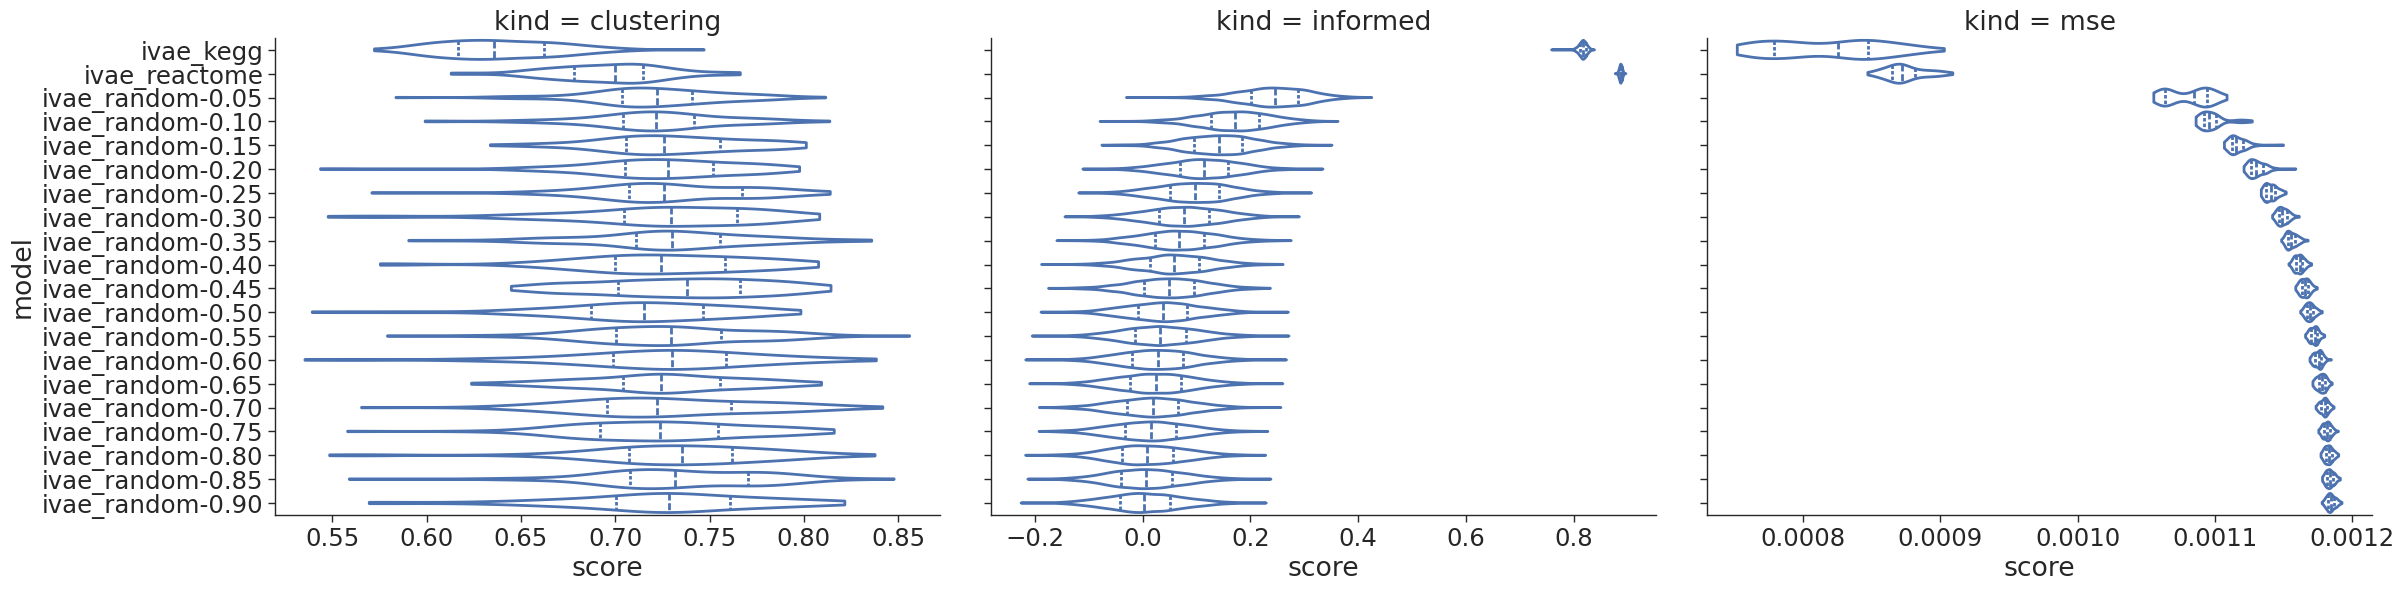

In [25]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context="paper", font_scale=2, style="ticks", rc=custom_params)
fac = 0.7

g = sns.catplot(
    data=scores,
    kind="violin",
    col="kind",
    height=9 * fac,
    aspect=16 / 9 * fac,
    sharey=True,
    sharex=False,
    y="model",
    x="score",
    split=False,
    cut=0,
    fill=False,
    density_norm="count",
    inner="quart",
    linewidth=2,
    legend_out=False,
    col_wrap=4,
)

In [26]:
informed_scores.groupby(["model", "kind", "split", "layer"]).describe()

score                                \
                                        count      mean       std       min   
model            kind     split layer                                         
ivae_kegg        informed test  1      4950.0  0.817058  0.007758  0.759153   
                                2      4950.0  0.538705  0.081254  0.198870   
                          train 1      4950.0  0.817205  0.007848  0.759626   
                                2      4950.0  0.536786  0.081407  0.189745   
                          val   1      4950.0  0.816569  0.007890  0.758540   
...                                       ...       ...       ...       ...   
ivae_random-0.90 informed train 1      4950.0  0.004697  0.067615 -0.213025   
                          val   1      4950.0  0.004873  0.067500 -0.221364   
ivae_reactome    informed test  1      4950.0  0.887835  0.002746  0.877257   
                          train 1      4950.0  0.888194  0.002723  0.877832   
                          val   1      4950.0  0.887967  0.002729  0.877611   

                                                                               
                                            25%       50%       75%       max  
model            kind     split layer                                          
ivae_kegg        informed test  1      0.812791  0.817631  0.822145  0.838730  
                                2      0.488912  0.546976  0.596996  0.746969  
                          train 1      0.812949  0.817817  0.822272  0.838844  
                                2      0.486487  0.544928  0.594969  0.746630  
                          val   1      0.812287  0.817170  0.821711  0.838540  
...                                         ...       ...       ...       ...  
ivae_random-0.90 informed train 1     -0.041427  0.003716  0.049846  0.235446  
                          val   1     -0.041546  0.003096  0.049993  0.235875  
ivae_reactome    informed test  1      0.886063  0.887864  0.889752  0.896972  
                          train 1      0.886414  0.888200  0.890092  0.897276  
                          val   1      0.886192  0.887993  0.889851  0.896991  

[63 rows x 8 columns]